In [1]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

name 'client' is not defined


In [2]:
import healpy as hp
import lsdb
import numpy as np
import sys
import pandas as pd
from astropy.coordinates import SkyCoord
sys.path.append('../src')

import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

pd.set_option('display.max_columns', None)

In [3]:
import healpy as hp

def get_healpix(nside, l, b):
    return hp.ang2pix(nside, l, b, lonlat=True)

##### Some testing.

In [4]:
print(hp.ang2pix(32, 174.816289, -48.991091, lonlat=True, nest=True))
print(hp.ang2pix(32, 174.816289, -48.991091, lonlat=True, nest=False))
print(hp.ang2pix(32, 43.945667, 0.938479, lonlat=True, nest=True))
print(hp.ang2pix(32, 43.945667, 0.938479, lonlat=True, nest=False))

9539
10828
0
5968


12288
10828
5968
9539
0


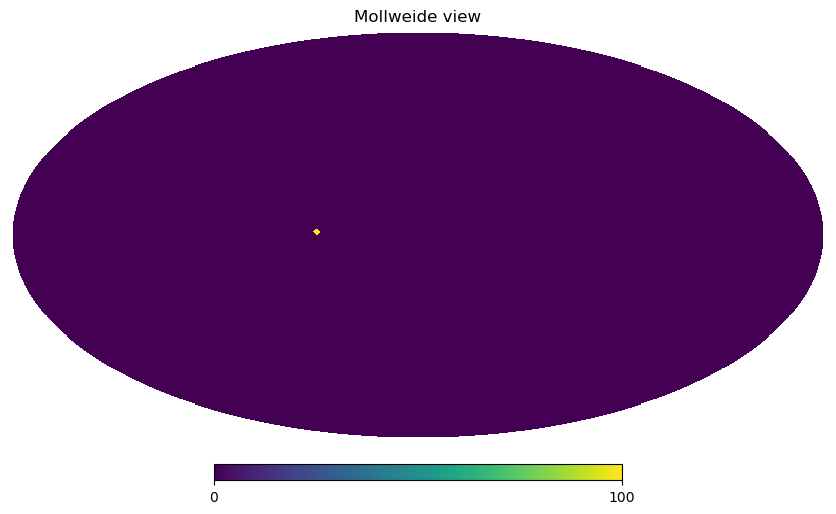

In [5]:
print(hp.nside2npix(32))
healpix_map=np.array([0] * hp.nside2npix(32))
# 10828
# 9539 True 
# glon glat
print(hp.ang2pix(32, 174.816289, -48.991091, lonlat=True, nest=False))
print(hp.ang2pix(32, 43.945667, 0.938479, lonlat=True, nest=False))
print(hp.ang2pix(32, 174.816289, -48.991091, lonlat=True, nest=True))
print(hp.ang2pix(32, 43.945667, 0.938479, lonlat=True, nest=True))

# val = get_healpix(32, 220, -10)
# val = get_healpix(32, 174.816289, -48.991091)
val = get_healpix(32, 43.945667, 0.938479)

healpix_map[val] = 100
hp.mollview(healpix_map)

#### Spin up the client.

In [4]:
from dask.distributed import Client

client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35231 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35231/status,
Dashboard: http://127.0.0.1:35231/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45243,Workers: 96
Dashboard: http://127.0.0.1:35231/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:39651,Total threads: 1
Dashboard: http://127.0.0.1:37777/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:33635,


Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

### Read HATS catalog and fix the columns. Done! don't repeat this, just skip to the column where the fixed/prepared S82 HATS cat is loaded.

CPU times: user 2 s, sys: 1.84 s, total: 3.84 s
Wall time: 9.96 s


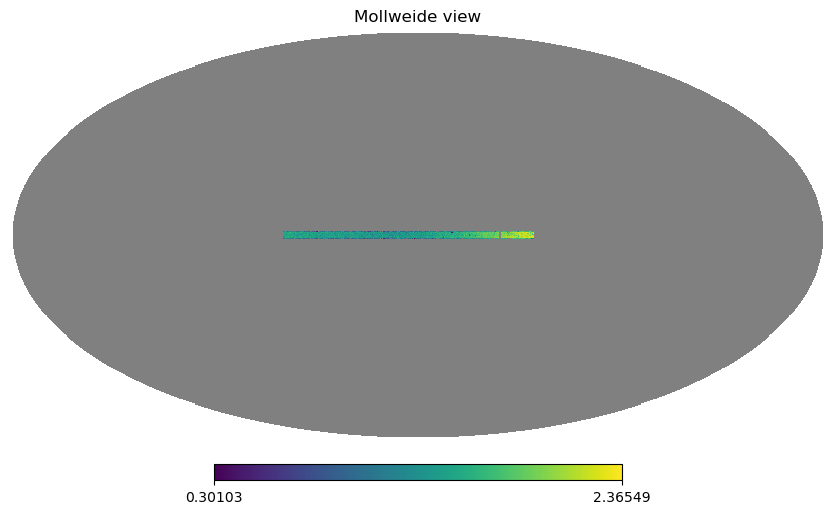

In [24]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_data_hats/")
s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

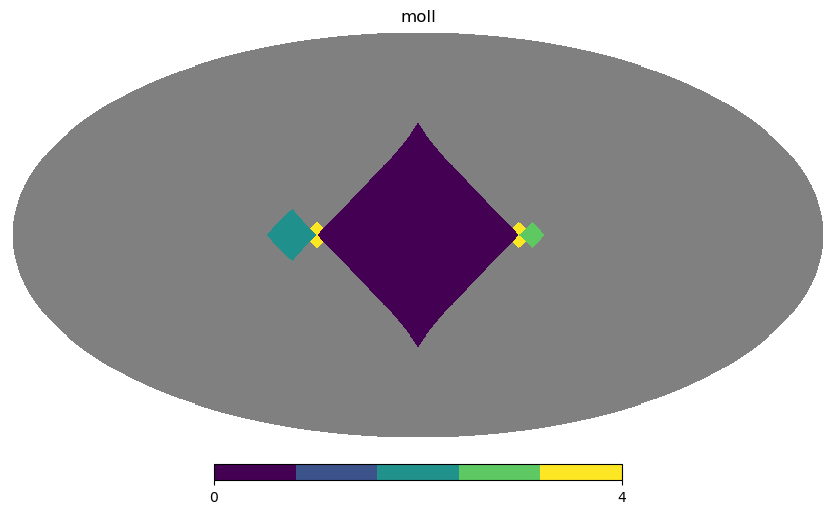

In [25]:
s82.plot_pixels()

In [26]:
s82.hc_structure.partition_info.get_healpix_pixels()

[Order: 4, Pixel: 0,
 Order: 4, Pixel: 768,
 Order: 0, Pixel: 4,
 Order: 2, Pixel: 90,
 Order: 3, Pixel: 469,
 Order: 4, Pixel: 2303,
 Order: 4, Pixel: 3071]

In [27]:
s82.head(3)

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,ummed,ummu,umsig,umrms,umchi2,gNobs,gmmed,gmmu,gmsig,gmrms,gmchi2,rNobs,rmmed,rmmu,rmsig,rmrms,rmchi2,iNobs,immed,immu,imsig,imrms,imchi2,zNobs,zmmed,zmmu,zmsig,zmrms,zmchi2,Norder,Dir,Npix
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
178820370416688,CALIBSTARS_0891163,43.787097,1.037784,0.0282,0.0282,24,0.256,23,19.544,19.547,0.007,0.044,1.034,22,17.958,17.958,0.004,0.015,0.71,21,17.287,17.288,0.003,0.004,0.302,22,17.024,17.027,0.003,0.014,0.949,23,16.886,16.891,0.004,0.017,0.835,4,0,0
178775253286992,CALIBSTARS_0891187,43.828101,1.040223,0.4066,0.4066,47,0.253,24,18.47,18.469,0.005,0.028,1.098,24,17.38,17.378,0.004,0.019,1.014,23,16.973,16.973,0.003,0.013,0.944,23,16.812,16.81,0.003,0.009,0.627,24,16.748,16.75,0.004,0.011,0.611,4,0,0
178692611270558,CALIBSTARS_0891200,43.831573,1.024147,0.0315,0.0315,25,0.254,8,22.873,22.887,0.136,0.15,0.342,24,20.266,20.267,0.006,0.022,0.76,23,18.816,18.814,0.004,0.009,0.45,25,18.018,18.023,0.003,0.015,0.829,25,17.567,17.566,0.005,0.018,0.706,4,0,0


Change some column names and add some columns (needed later on), and apply the gi cut.

### Read the prepared catalog.

CPU times: user 2.44 s, sys: 2.34 s, total: 4.79 s
Wall time: 12.7 s


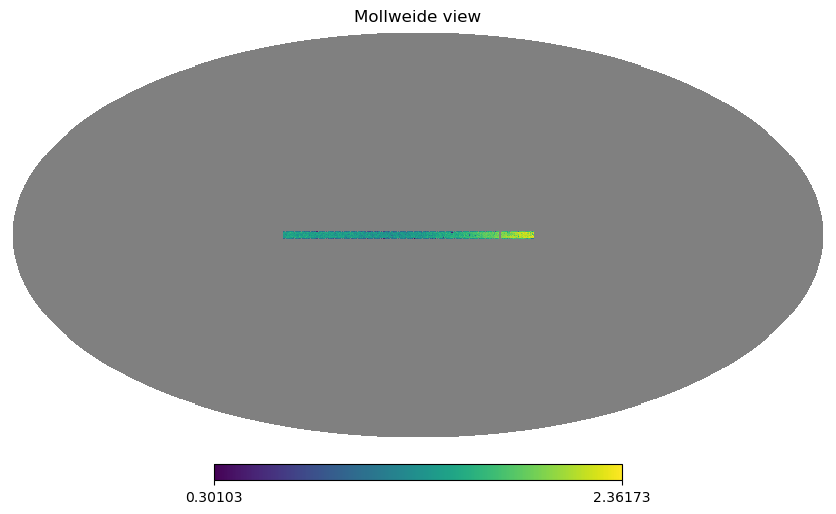

In [5]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

#### Sanity checks

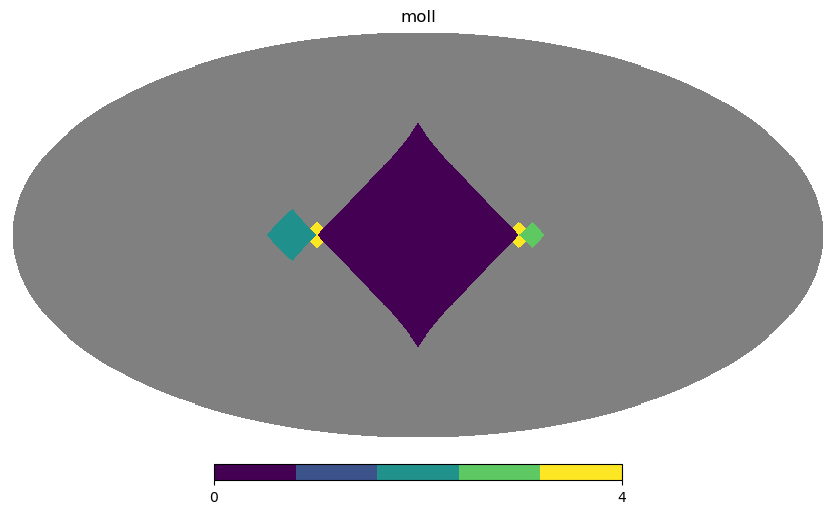

In [29]:
s82.plot_pixels()

In [30]:
s82.hc_structure.partition_info.get_healpix_pixels()

[Order: 4, Pixel: 0,
 Order: 4, Pixel: 768,
 Order: 0, Pixel: 4,
 Order: 2, Pixel: 90,
 Order: 3, Pixel: 469,
 Order: 4, Pixel: 2303,
 Order: 4, Pixel: 3071]

### Continue with the example

In [6]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False) # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [7]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [8]:
catalog = s82
fitColors = ('ug', 'gr', 'ri', 'iz')
# priorsRootName = 'results/S82_priors/5/0'
print(hp.ang2pix(32, 43.949496, 1.042666, lonlat=True, nest=True)) # * 36
print(hp.ang2pix(32, 314.884183, 0.323769, lonlat=True, nest=True)) # * 13336 
priorsRootName1 = '/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0'
priorsRootName2 = '/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/3072'
# priorsRootName = 'results/S82_priors/5/0'
outfile = 'results/S82_Bayes_estimates.txt'

0
3072


In [45]:
df.iloc[13336]

CALIBSTARS    CALIBSTARS_0167362
ra                    314.884183
dec                     0.323769
RArms                     0.0349
Decrms                    0.0349
Ntot                          16
Ar                         0.223
uNobs                          4
umag                      24.101
ummu                      24.091
uErr                       0.588
umrms                      0.132
umchi2                     0.106
gNobs                         15
gmag                      22.212
gmmu                      22.199
gErr                       0.035
gmrms                      0.165
gmchi2                     0.993
rNobs                         15
rmag                      20.722
rmmu                      20.689
rErr                       0.017
rmrms                       0.07
rmchi2                     0.637
iNobs                         14
imag                       19.79
immu                      19.772
iErr                       0.014
imrms                      0.038
imchi2    

Make 3D locus list with three ArGrid limits and resolutions.

In [9]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [10]:
iStart = 0
iEnd = -1 # if<0: do all stars
# myStars = [0, 100, 1000, 10000] # for illustration, make plots for these stars
myStars = [36, 13336] # no plots
verb=True

In [13]:
ls /mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/*npz # | wc -l 9539 10828 0 5968

/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-00.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-01.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-02.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-03.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-04.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-05.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-06.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-07.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-08.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-09.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-10.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-11.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-12.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-13.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-14.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-15.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0-16.npz
/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0

#### A variety of checks, etc.

<Axes: >

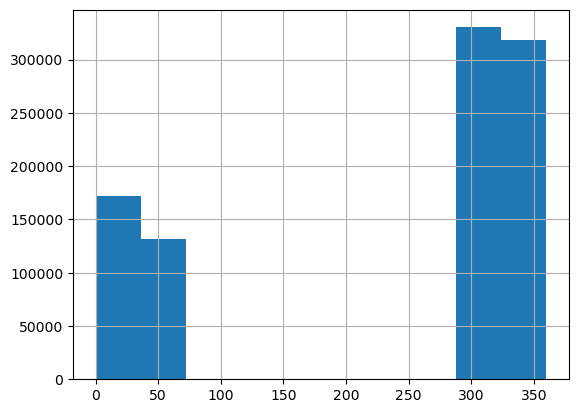

In [24]:
catalog['ra'].compute().hist()

<Axes: >

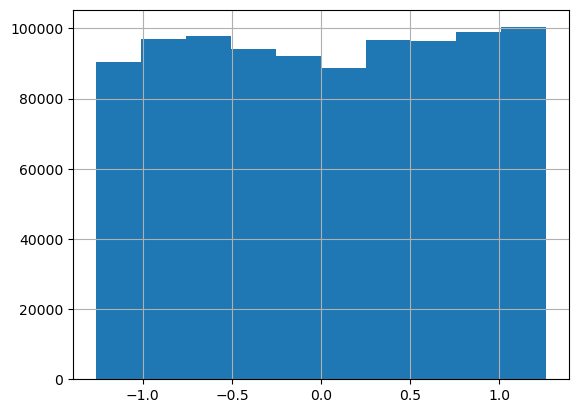

In [25]:
catalog['dec'].compute().hist()

In [26]:
df = catalog.pixel_search([(5,0)]).compute()
df.Mr*0.0

_healpix_29
178820370416688   -0.0
178775253286992   -0.0
178692611270558   -0.0
178139752091901   -0.0
178442591206321   -0.0
                  ... 
90087767328837    -0.0
92399396454365    -0.0
95986517511105    -0.0
281767297668982   -0.0
94384403570284    -0.0
Name: Mr, Length: 3981, dtype: double[pyarrow]

In [47]:
catalog['Npix'].compute().unique()

<ArrowExtensionArray>
[0, 768, 4, 90, 469, 2303, 3071]
Length: 7, dtype: int64[pyarrow]

In [49]:
catalog['Norder'].compute().unique()

<ArrowExtensionArray>
[4, 0, 2, 3]
Length: 4, dtype: int8[pyarrow]

In [50]:
catalog['Dir'].compute().unique()

<ArrowExtensionArray>
[0]
Length: 1, dtype: int64[pyarrow]

#### Continue ...

In [12]:
df = catalog.compute()

In [14]:
df

,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
178820370416688,CALIBSTARS_0891163,43.787097,1.037784,0.0282,0.0282,24,0.256,23,19.544,19.547,0.007,0.044,1.034,22,17.958,17.958,0.004,0.015,0.71,21,17.287,17.288,0.003,0.004,0.302,22,17.024,17.027,0.003,0.014,0.949,23,16.886,16.891,0.004,0.017,0.835,4,0,0,-99,-99,-99,-99,-99,1.586,0.671,0.934,0.263,0.138,0.008062,0.005,0.005,0.004243,0.005,174.537601,-49.030895
178775253286992,CALIBSTARS_0891187,43.828101,1.040223,0.4066,0.4066,47,0.253,24,18.47,18.469,0.005,0.028,1.098,24,17.38,17.378,0.004,0.019,1.014,23,16.973,16.973,0.003,0.013,0.944,23,16.812,16.81,0.003,0.009,0.627,24,16.748,16.75,0.004,0.011,0.611,4,0,0,-99,-99,-99,-99,-99,1.09,0.407,0.568,0.161,0.064,0.006403,0.005,0.005,0.004243,0.005,174.579778,-49.000538
178692611270558,CALIBSTARS_0891200,43.831573,1.024147,0.0315,0.0315,25,0.254,8,22.873,22.887,0.136,0.15,0.342,24,20.266,20.267,0.006,0.022,0.76,23,18.816,18.814,0.004,0.009,0.45,25,18.018,18.023,0.003,0.015,0.829,25,17.567,17.566,0.005,0.018,0.706,4,0,0,-99,-99,-99,-99,-99,2.607,1.45,2.248,0.798,0.451,0.136132,0.007211,0.006708,0.005,0.005831,174.600676,-49.009624
178139752091901,CALIBSTARS_0891206,43.870259,0.983584,0.0259,0.0259,25,0.253,25,21.136,21.113,0.019,0.09,0.76,25,19.771,19.775,0.005,0.019,0.586,25,19.245,19.242,0.004,0.016,0.742,25,19.03,19.033,0.004,0.017,0.784,24,18.919,18.924,0.01,0.036,0.787,4,0,0,-99,-99,-99,-99,-99,1.365,0.526,0.741,0.215,0.111,0.019647,0.006403,0.006403,0.005657,0.01077,174.686073,-49.011621
178442591206321,CALIBSTARS_0891209,43.884348,1.028387,0.0506,0.0506,25,0.251,25,19.421,19.411,0.007,0.036,1.13,25,17.74,17.738,0.004,0.021,0.949,25,17.089,17.09,0.003,0.011,0.764,24,16.85,16.848,0.003,0.016,1.029,23,16.731,16.73,0.004,0.014,0.744,4,0,0,-99,-99,-99,-99,-99,1.681,0.651,0.89,0.239,0.119,0.008062,0.005,0.005,0.004243,0.005,174.653707,-48.969732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458587837391950679,CALIBSTARS_0218913,316.124689,-0.984808,0.0322,0.0322,16,0.175,12,21.903,21.876,0.058,0.182,0.693,14,21.165,21.165,0.013,0.032,0.688,15,20.899,20.895,0.013,0.036,0.57,16,20.793,20.768,0.017,0.051,0.701,10,20.744,20.665,0.066,0.158,0.791,4,0,3071,-99,-99,-99,-99,-99,0.738,0.266,0.372,0.106,0.049,0.059439,0.018385,0.021401,0.021401,0.068154,48.618385,-29.731558
3458588330308145677,CALIBSTARS_0218915,316.057052,-0.95856,0.0349,0.0349,15,0.185,9,22.975,22.955,0.138,0.163,0.371,15,21.535,21.545,0.017,0.071,0.908,14,21.02,21.002,0.015,0.055,1.019,15,20.82,20.774,0.017,0.068,1.157,13,20.602,20.582,0.054,0.096,0.502,4,0,3071,-99,-99,-99,-99,-99,1.44,0.515,0.715,0.2,0.218,0.139043,0.022672,0.024042,0.022672,0.056613,48.604161,-29.660076
3458587856950236370,CALIBSTARS_0218917,316.133306,-0.971373,0.041,0.041,16,0.174,3,24.789,24.878,0.611,0.09,0.095,13,22.356,22.341,0.034,0.075,0.577,16,21.081,21.081,0.015,0.061,0.923,16,20.525,20.51,0.013,0.057,1.156,13,20.048,20.061,0.034,0.2,1.482,4,0,3071,-99,-99,-99,-99,-99,2.433,1.275,1.831,0.556,0.477,0.611945,0.037162,0.036401,0.019849,0.036401,48.636757,-29.732016


priorsRootName: /mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/3072
rootname: /mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/3072
Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
working on star 0


/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py:1075: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['chi2min'][i] = np.min(chi2map)
/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py

pts: 25 155


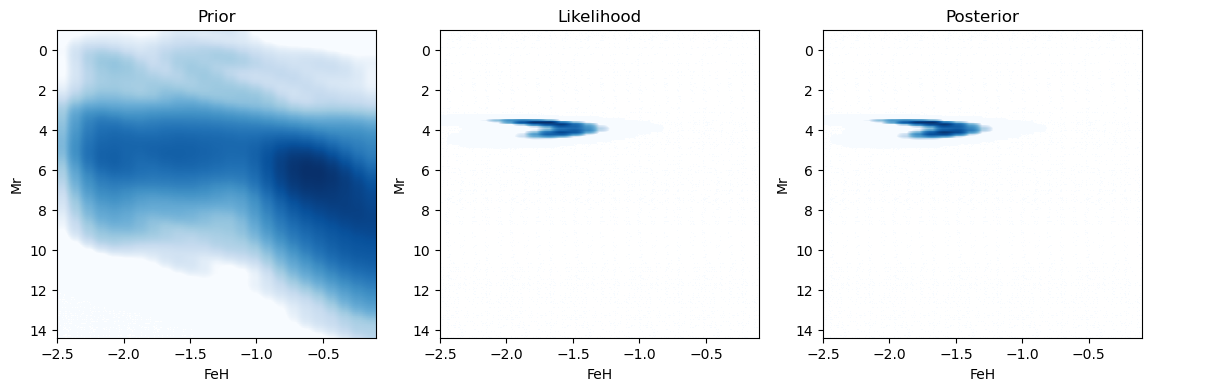

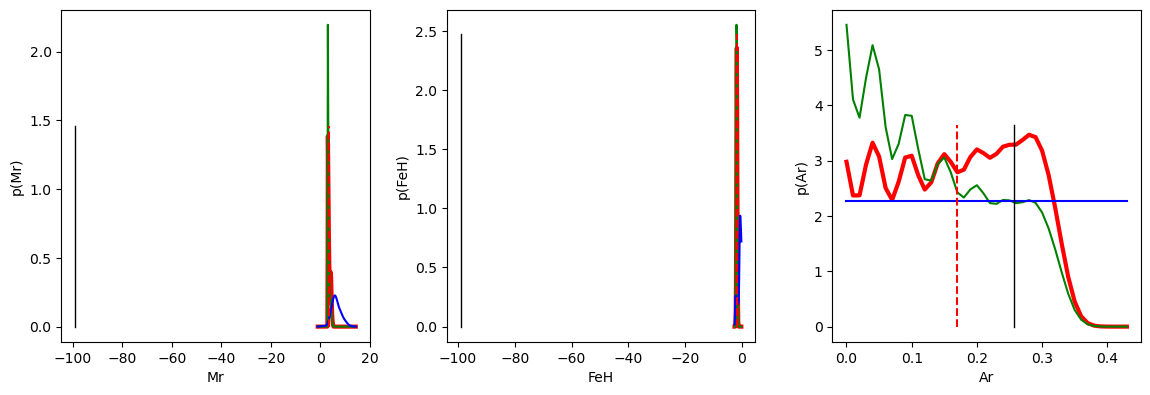

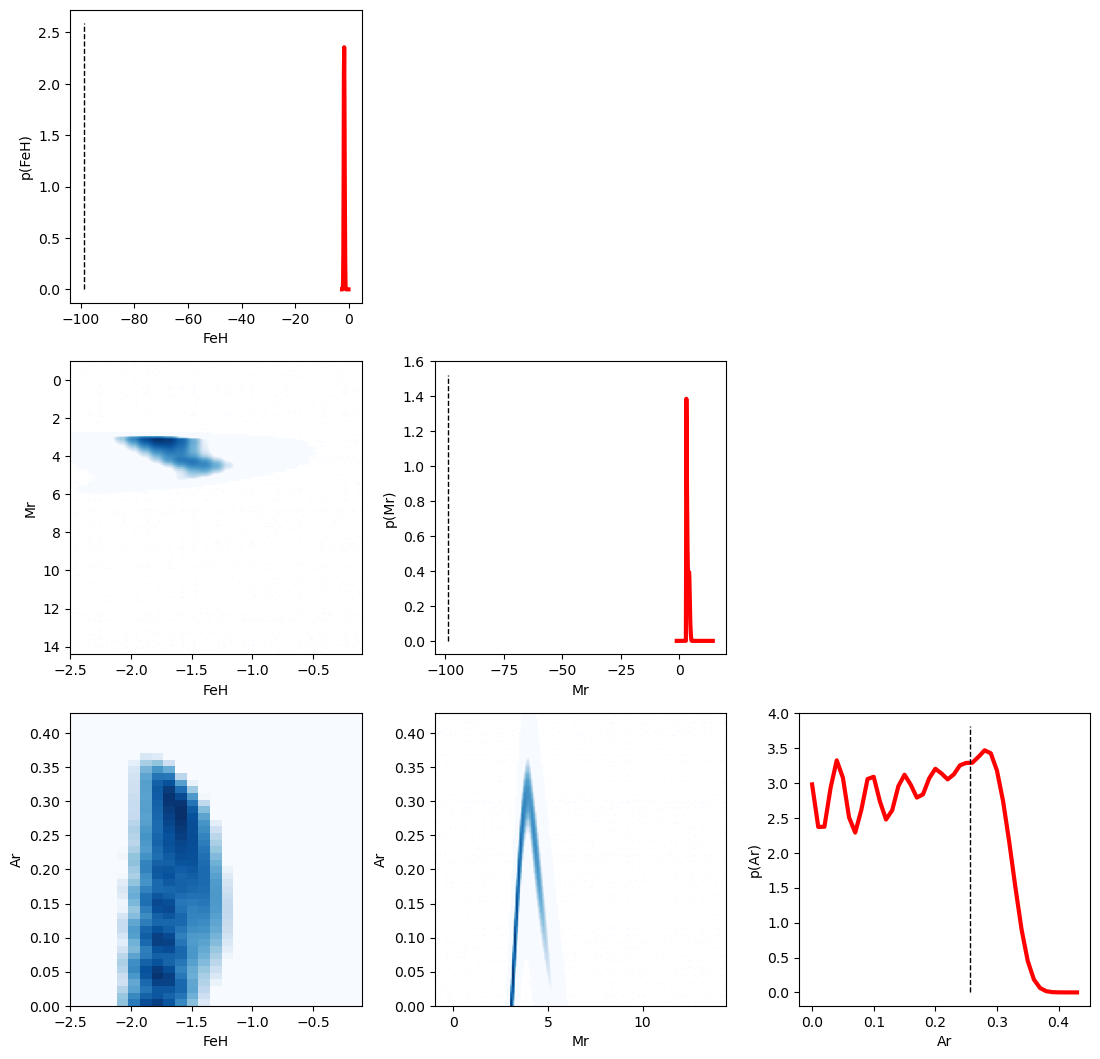

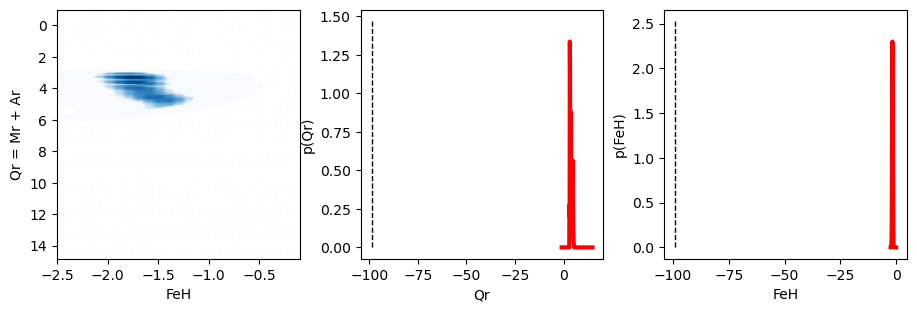

/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py:1127: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog['QrEst'][i], catalog['QrEstUnc'][i] = getStats(Qr1d, margpostQr)


 *** 3D Bayes results for star i= 36
r mag: 20.047 g-r: 0.34999999999999787 chi2min: 6.7687310140546595
Mr: true= -99 estimate= 3.6264879433519392  +-  0.5153178699256085
FeH: true= -99 estimate= -1.6822654947097497  +-  0.1698704479608704
Ar: true= 0.257 estimate= 0.16987184686981627  +-  0.09766487714902582
Qr: true= -98.743 estimate= 3.856069802635452  +-  0.5690682176240537
Mr drop in entropy: -22.97791285903157
FeH drop in entropy: -14.7566725310387
Ar drop in entropy: -32.44878990572262


/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/BayesTools.py:435: RuntimeWarning: invalid value encountered in divide
  return pdf/np.sum(pdf)/dx


working on star 10000
pts: 25 155


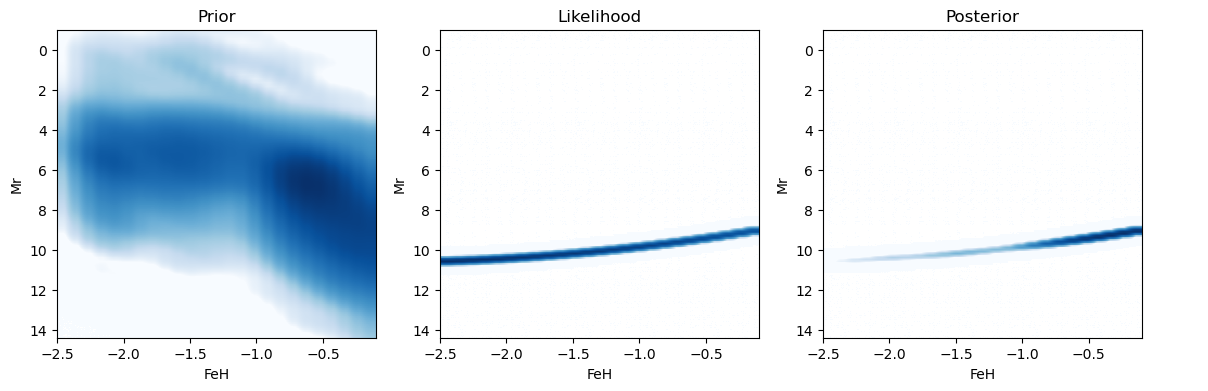

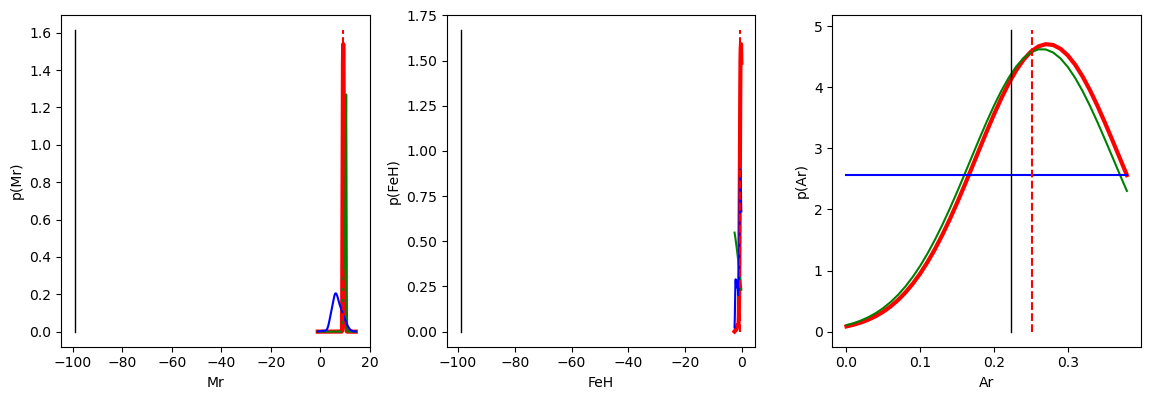

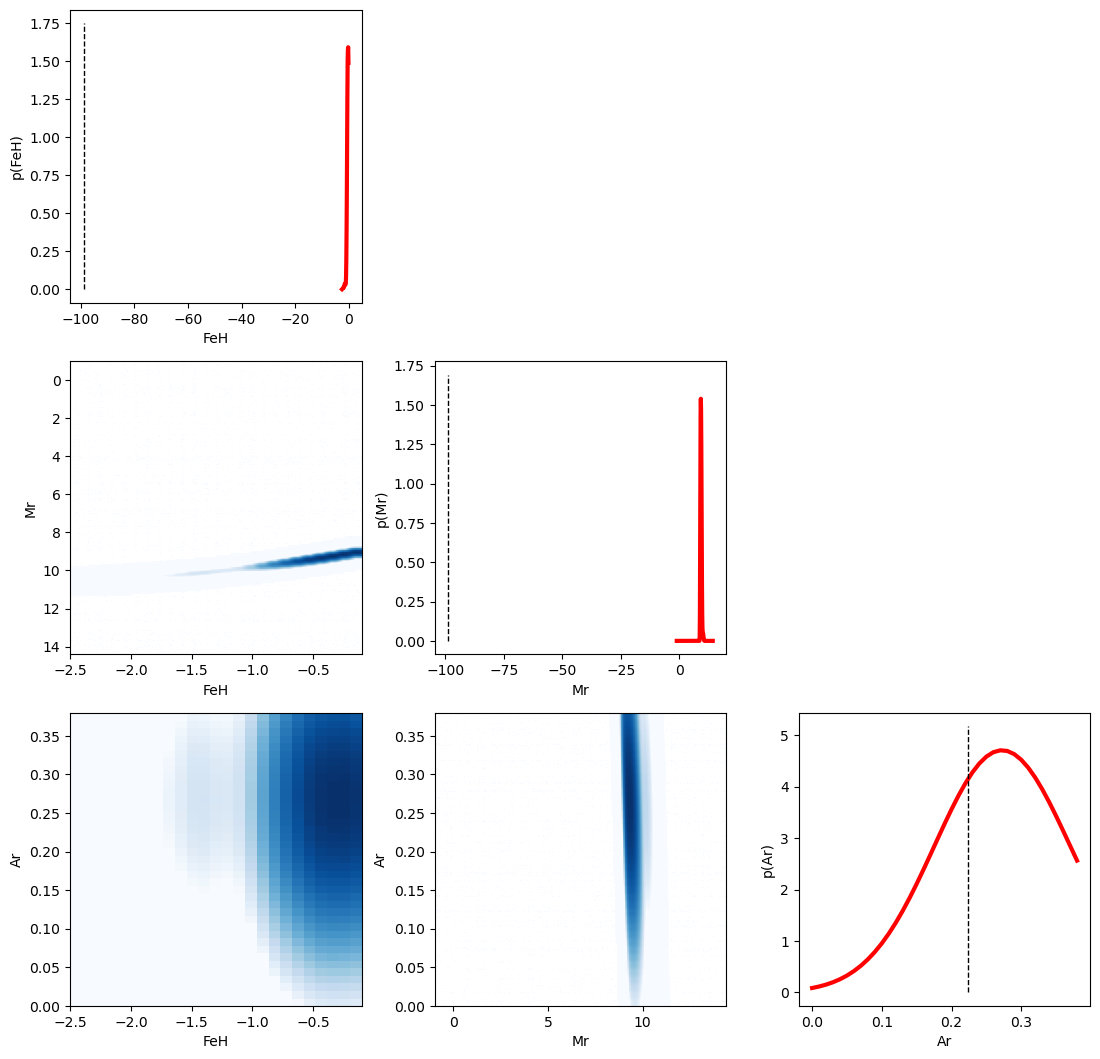

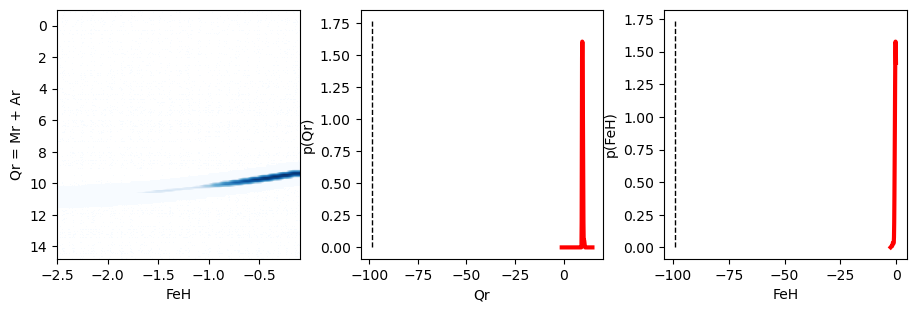

 *** 3D Bayes results for star i= 13336
r mag: 20.722 g-r: 1.4899999999999984 chi2min: 1.4862721266101917
Mr: true= -99 estimate= 9.385380146068757  +-  0.26799293431234344
FeH: true= -99 estimate= -0.42065728613521974  +-  0.28916233790003004
Ar: true= 0.223 estimate= 0.2510480074147346  +-  0.07839558337501451
Qr: true= -98.777 estimate= 9.68789173210216  +-  0.2577817461238914
Mr drop in entropy: -30.387380591155747
FeH drop in entropy: -11.233737881312539
Ar drop in entropy: -36.79969935532279
working on star 20000


ValueError: zero-size array to reduction operation minimum which has no identity

In [13]:
%%time

import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import importlib
importlib.reload(lt)
importlib.reload(bt)
importlib.reload(pt)


bt.makeBayesEstimates3D(df.reset_index(drop=True), fitColors, locusData, locus3DList, ArGridList, 
                        priorsRootName2, outfile, iStart, iEnd, myStars, verbose=verb)